<a href="https://colab.research.google.com/github/Tariq32/Hello-World/blob/master/Disney%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tweepy vaderSentiment scikit-learn pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [4]:
import tweepy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (only needs to succeed once)
nltk.download('vader_lexicon')

# ---------- X / Twitter API setup ----------
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAHSe5gEAAAAAZfAt1tjS6EljSNeiStiaOxfWBUc%3DPSnn8mGMPRUnt5jujX8Phv8oniihWrvXrTvyiFxqhD7l5lVzuB"   # keep this secret!

client = tweepy.Client(bearer_token=BEARER_TOKEN)

# ---------- Fetch recent Disney tweets ----------
query = "Disney lang:en"
tweets = client.search_recent_tweets(query=query, max_results=20)

tweet_texts = [tweet.text for tweet in tweets.data]
print(f"Fetched {len(tweet_texts)} tweets.\n")

# ---------- Sentiment analysis with VADER ----------
sia = SentimentIntensityAnalyzer()
sentiment_results = []

for text in tweet_texts:
    scores = sia.polarity_scores(text)   # gives pos, neu, neg, compound
    compound = scores["compound"]

    if compound > 0.05:
        label = "positive"
    elif compound < -0.05:
        label = "negative"
    else:
        label = "neutral"

    sentiment_results.append((text, compound, label))

# ---------- Summary counts ----------
pos = sum(1 for _, _, l in sentiment_results if l == "positive")
neg = sum(1 for _, _, l in sentiment_results if l == "negative")
neu = sum(1 for _, _, l in sentiment_results if l == "neutral")

print("\nSentiment summary:")
print(f"Positive: {pos}")
print(f"Neutral : {neu}")
print(f"Negative: {neg}")

# ---------- Show a few example tweets ----------
print("\nSample labeled tweets:\n")
for i, (text, comp, label) in enumerate(sentiment_results[:5], start=1):
    print(f"{i}. [{label} | {comp:.3f}] {text}\n")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Fetched 20 tweets.


Sentiment summary:
Positive: 6
Neutral : 10
Negative: 4

Sample labeled tweets:

1. [positive | 0.637] RT @ArtCelineLove: i love old disney aesthetic&lt;3 https://t.co/sks6r0V7sH

2. [neutral | 0.000] RT @catsuka: Don Bluth Interview (30 min) : The Secret of Nimh, Dragon's Lair, leaving Disney Studios, and more.
&gt;&gt; https://t.co/XmhviNl1h3…

3. [positive | 0.494] @retroboy1983 @ArtofDominique1 Knowing Disney it'll be hand painted by SORA or something

4. [neutral | 0.000] RT @ArtCelineLove: old disney at night&lt;3 https://t.co/IpzQm20M1w

5. [negative | -0.077] RT @AvengersUpdated: Disney+ continues teasing ‘AVENGERS: DOOMSDAY’

“They’ve already started preparing for the meeting… and you, what’s yo…



In [21]:
import pandas as pd
import plotly.express as px

# Convert sentiment_results → a DataFrame
df = pd.DataFrame(sentiment_results, columns=['Text', 'Score', 'Sentiment'])

# Count each sentiment type
sentiment_counts = df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Create a nice bar chart
fig = px.bar(
    sentiment_counts,
    x='Sentiment',
    y='Count',
    title='Sentiment Distribution of Disney Tweets (n=20)',
    color='Sentiment',
    text='Count'
)

fig.show()
plt.savefig("cluster0_terms.png", dpi=300, bbox_inches='tight')



<Figure size 640x480 with 0 Axes>

In [11]:
! pip install -U kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: kaleido
    Found existing installation: kaleido 1.2.0
    Uninstalling kaleido-1.2.0:
      Successfully uninstalled kaleido-1.2.0


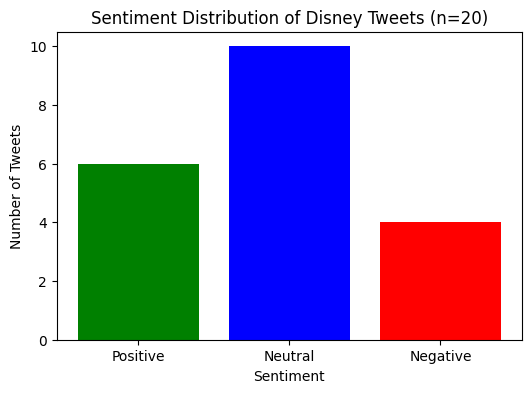

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Your real sentiment numbers
positive = 6
neutral = 10
negative = 4

labels = ["Positive", "Neutral", "Negative"]
values = [positive, neutral, negative]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["green", "blue", "red"])
plt.title("Sentiment Distribution of Disney Tweets (n=20)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")

plt.savefig("disney_sentiment_chart.png", dpi=300, bbox_inches='tight')
plt.show()
plt.savefig("cluster0_terms.png", dpi=300, bbox_inches='tight')

In [14]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform([text for text, _, _ in sentiment_results])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

clusters = kmeans.labels_
cluster_df = pd.DataFrame({'tweet': [text for text,score,label in sentiment_results], 'cluster': clusters})
cluster_df.head()


,tweet,cluster
0,RT @ArtCelineLove: i love old disney aesthetic...,1
1,RT @catsuka: Don Bluth Interview (30 min) : Th...,2
2,@retroboy1983 @ArtofDominique1 Knowing Disney ...,1
3,RT @ArtCelineLove: old disney at night&lt;3 ht...,1
4,RT @AvengersUpdated: Disney+ continues teasing...,1


In [19]:
import plotly.express as px
cluster_counts = cluster_df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

fig_cluster = px.bar(cluster_counts, x='Cluster', y='Count', title='User Segments')
fig_cluster.show()
plt.savefig("cluster1_terms.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [16]:

import numpy as np

# Get feature names and cluster centroids
terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_  # shape: (n_clusters, n_features)

# Number of top terms to display
TOP_N = 12

# Sort indices of terms by descending weight per cluster
order = np.argsort(centroids, axis=1)[:, ::-1]

for i in range(kmeans.n_clusters):
    print(f"\n=== Cluster {i} — Top {TOP_N} terms ===")
    top_idx = order[i, :TOP_N]
    for j, idx in enumerate(top_idx, start=1):
        print(f"{j:2d}. {terms[idx]} (weight: {centroids[i, idx]:.4f})")



=== Cluster 0 — Top 12 terms ===
 1. day (weight: 0.2401)
 2. watch (weight: 0.1442)
 3. spe (weight: 0.1442)
 4. movie (weight: 0.1442)
 5. kid (weight: 0.1442)
 6. triggered (weight: 0.1442)
 7. gummi_bunnie (weight: 0.1442)
 8. cause (weight: 0.1442)
 9. adult (weight: 0.1442)
10. ass (weight: 0.1442)
11. fully (weight: 0.1442)
12. grown (weight: 0.1442)

=== Cluster 1 — Top 12 terms ===
 1. disney (weight: 0.0980)
 2. https (weight: 0.0965)
 3. rt (weight: 0.0928)
 4. artcelinelove (weight: 0.0712)
 5. old (weight: 0.0712)
 6. doomsday (weight: 0.0510)
 7. avengers (weight: 0.0510)
 8. lt (weight: 0.0494)
 9. christmas (weight: 0.0460)
10. world (weight: 0.0457)
11. ph (weight: 0.0444)
12. preparing (weight: 0.0398)

=== Cluster 2 — Top 12 terms ===
 1. gt (weight: 0.2410)
 2. 30 (weight: 0.2293)
 3. state (weight: 0.1404)
 4. set (weight: 0.1404)
 5. tarleton (weight: 0.1404)
 6. tarletonfb (weight: 0.1404)
 7. football (weight: 0.1404)
 8. ct (weight: 0.1404)
 9. air (weight: 0.

In [18]:

import plotly.express as px
import pandas as pd
import numpy as np

TOP_N = 10
terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_
order = np.argsort(centroids, axis=1)[:, ::-1]

for i in range(kmeans.n_clusters):
    top_idx = order[i, :TOP_N]
    top_terms = terms[top_idx]
    top_weights = centroids[i, top_idx]

    chart_df = pd.DataFrame({
        'term': top_terms,
        'weight': top_weights
    }).sort_values('weight', ascending=True)  # sort for horizontal bar

    fig = px.bar(
        chart_df,
        x='weight',
        y='term',
        orientation='h',
        title=f'Top {TOP_N} Terms — Cluster {i}',
        labels={'weight': 'TF-IDF centroid weight', 'term': 'Term'},
        height=500
    )
    fig.show()
    plt.savefig("cluster1_terms.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example TF-IDF terms for the cluster (replace with your variables)
terms = cluster0_terms   # replace with your actual list of top terms
weights = cluster0_weights  # replace with your weights

plt.figure(figsize=(8,5))
plt.barh(terms, weights)
plt.title("Top 10 Terms — Cluster 0")
plt.xlabel("TF-IDF centroid weight")
plt.ylabel("Term")

plt.savefig("cluster0_terms.png", dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'cluster0_terms' is not defined